# 1. Domača naloga: AutoML

V prvi domači nalogi se bomo ukvarjali z AutoML oziroma natančneje z uporabo knjižnjice Hyperopt, ki nam omogoča avtomatsko izbiranje najboljše konfiguracije izbranih algoritmov za klasifikacijo. Natančnejši opis vseh metod in odločitev je v priloženi pdf datoteki.

# 1. UVOD

In [1]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random 

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, SVC
from hyperopt import hp, tpe, rand, fmin, Trials, space_eval
from hyperopt import pyll, base

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import scale, normalize, MinMaxScaler
from sklearn.decomposition import PCA

# POZOR! Opozorila skrijemo izključno zaradi opozoril pri sns.distplot.
import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset = pd.read_csv('podatki.csv', sep=',')
x, y = dataset.iloc[:, :-1], dataset.iloc[:, -1]

Poglejmo si najprej s kakšnimi podatki operiramo.

In [3]:
dataset

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x22,x23,x24,x25,x26,x27,x28,x29,x30,y
0,2.0,2.12,3.0,11.0,7.56,54.81,14.0,69.0,10.0,11.13,...,96.0,4404.26,484.15,246.57,2.50,4.0,4.0,4.0,4.0,teamEdward
1,2.0,2.50,2.0,3.0,2.00,20.13,12.0,15.0,13.0,9.50,...,36.0,1022.00,138.00,58.67,2.33,2.0,2.0,2.0,4.0,teamEdward
2,5.0,2.32,6.0,11.0,22.00,25.15,20.0,52.0,40.0,31.25,...,140.0,19808.66,679.15,1102.37,2.10,2.0,2.0,2.0,9.0,teamEdward
3,2.0,2.17,56.0,14.0,83.82,31.79,13.0,141.0,13.0,10.94,...,58.0,2381.82,268.27,134.21,2.50,2.0,2.0,2.0,3.0,teamEdward
4,2.0,2.36,2.0,3.0,2.00,26.22,18.0,15.0,16.0,14.71,...,63.0,3911.70,309.71,219.21,2.75,2.0,2.0,2.0,4.0,teamEdward
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1198,13.0,2.14,19.0,33.0,29.45,73.39,20.0,137.0,63.0,26.46,...,293.0,42703.09,1748.00,2374.28,2.33,23.0,4.0,22.0,12.0,teamJacob
1199,6.0,2.27,2.0,5.0,38.36,22.85,11.0,18.0,11.0,7.00,...,27.0,523.24,106.25,30.96,2.33,6.0,4.0,6.0,4.0,teamJacob
1200,6.0,2.22,13.0,24.0,33.91,45.42,18.0,73.0,37.0,16.61,...,122.0,9267.54,636.25,516.75,2.13,15.0,4.0,14.0,7.0,teamJacob
1201,3.0,2.13,5.0,9.0,17.38,24.30,14.0,39.0,14.0,15.80,...,71.0,4248.27,309.70,237.90,2.33,6.0,4.0,6.0,5.0,teamJacob


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1203 entries, 0 to 1202
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      1203 non-null   float64
 1   x2      1203 non-null   float64
 2   x3      1203 non-null   float64
 3   x4      1203 non-null   float64
 4   x5      1203 non-null   float64
 5   x6      1203 non-null   float64
 6   x7      1203 non-null   float64
 7   x8      1203 non-null   float64
 8   x9      1203 non-null   float64
 9   x10     1203 non-null   float64
 10  x11     1203 non-null   float64
 11  x12     1203 non-null   float64
 12  x13     1203 non-null   float64
 13  x14     1203 non-null   float64
 14  x15     1203 non-null   float64
 15  x16     1203 non-null   float64
 16  x17     1203 non-null   float64
 17  x18     1203 non-null   float64
 18  x19     1203 non-null   float64
 19  x20     1203 non-null   float64
 20  x21     1203 non-null   float64
 21  x22     1203 non-null   float64
 22  

### (A) Prvi problem

Uporabiti moramoo torej stratificirano vzorčenje ("po obliki y"), saj sta ciljni spremenljivki neuravnoteženi ("teamEdward": 1025 in "teamJacob": 178).

Če si pogledamo ciljno spremenljivko, vidimo v čem je problem.

In [5]:
edward = len([i for i in dataset["y"] if i == "teamEdward"])
jacob = len([i for i in dataset["y"] if i == "teamJacob"])
print("teamEdward:", edward, "\nteamJacob:", jacob)

teamEdward: 1025 
teamJacob: 178


### (B) Drugi problem

Opazimo lahko, da podatki niso skalirani. To je velik problem predvsem za klasifikacijo s podpornimi vektorji (SVM), saj ta deluje izredno počasi na neskaliranih podatkih. Katero skaliranje bomo uporabili? Na voljo imamo
- standardno skaliranje,
- normalizacijo,
- skaliranje minmax.

Pomembno je, katero klasifikacijo izberemo, saj so podatki pri večini značilk zamaknjeni v levo ("positive skewness" oz. "right skewness"). Podatki pri nekaterih značilkah imajo sicer drugačno obliko, vendar kar je pomembno je to, da ne moremo uporabiti predpostavke o normalnosti podatkov! 

Več o tem in o izbiri metode skaliranja bomo razložili v priloženi razpravi. 

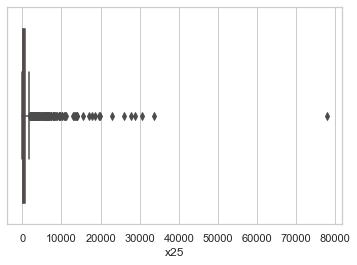

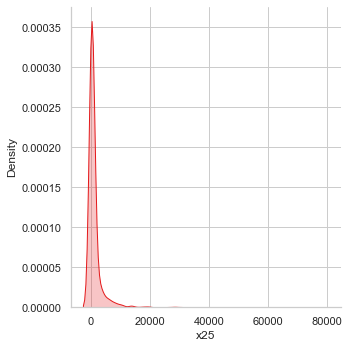

In [6]:
nakljucna = random.choice(range(1,31))
znacilka = "x"+str(nakljucna)
sns.set_theme(style="whitegrid", palette="Set1")
ax1 = sns.boxplot(x=dataset[znacilka])
ax2 = sns.displot(dataset, x=znacilka, kind="kde", fill=True)

## 1.2 Predprocesiranje podatkov

Kot smo opazili v prvem delu naloge imamo problem s klasifikatorjem SVC (metoda podpornih vektorjev). Nampreč, klasifikator je izredno počasen. Razloga za to sta dva: veliko število značilk ali neskalirani podatki.

Ker značilk ni veliko (uporabimo lahko tudi kakšno metodo za zmanjševanje dimenzije in bomo videli, da to ni problem), se problem skriva v tem, da podatkov nismo normalizirali preden smo začeli delati z njimi. Poglejmo si torej še enkrat vse skupaj, le da tokrat vključimo med naše algoritme tudi SVC.

Torej bo naša delitev in standarizavija podatkov potekala takole.

In [7]:
x_norm = (x - x.mean()) / (x.max() - x.min())
x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size=0.25, random_state=123, stratify=y)

# 2. ISKANJE NAJBOLJŠEGA ALGORITMA (VREČENJE vs. VSI OSTALI)

## 2.1 Izbor najboljšega algoritma

Prava moč paketa Hyperopt se pokaže šele, ko za vse algoritme preiskujemo prostor možnih konfiguracij simultano.

Iskali bomo najboljši algoritem med 
- k najbližjimi sosedi,
- Naključni gozd,
- Metodo podpornih vektorjev,
- Logistično regresijo.

Poglejmo si sedaj, kateri izmed teh algoritmov se odreže najbolje na naših podatkih.

In [8]:
# konstruiramo gnezdeni prostor vseh algoritmov in njihovih parametrov
gnezdeni_prostor = {
    "algo": hp.choice('algo', [
        {
            'ime': 'knn',
            'n_neighbors': hp.choice('n_neighbors', range(1, 21)),
            'weights': hp.choice('weights', ['uniform', 'distance'])
        },
        {
            'ime': 'gozd',
            'n_estimators': hp.choice('n_estimators', range(1, 51)),
            'max_depth': hp.choice('max_depth', range(1, 21)),
            'criterion': hp.choice('criterion', ["gini", "entropy"]),
        },
        {
            'ime': 'svm',
            'C': hp.lognormal('C', 0, 1),
            'kernel': hp.choice('kernel', [
                {
                    'tip': 'linear'  # linearno
                },
                {
                    'tip': 'rbf',  # radialno
                    'gamma': hp.lognormal('gamma', 0, 1)
                },
                {
                    'tip': 'poly',  # polinomsko
                    'degree': hp.choice('degree', [1, 2, 3, 4, 5])
                }
            ]),
        },
        {
            'ime': 'logreg',
            'solver': hp.choice('solver', ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]),
            'C1': hp.lognormal('C1', 0, 1),  # poimenovati ga moramo drugače kot C v primeru svm!
            'max_iter': hp.choice('max_iter', [50, 100, 150])
        },
    ])
}

In [9]:
def kriterijska_funkcija_skupna(parametri):
    a = parametri["algo"]
    ime_algoritma = a["ime"]
    
    if ime_algoritma == "knn":
        n_neighbors = a["n_neighbors"]
        weights = a["weights"]
        model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
        
    elif ime_algoritma == "gozd":
        n_estimators = a["n_estimators"]
        max_depth = a["max_depth"]
        criterion = a["criterion"]
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, criterion=criterion)
        
    elif ime_algoritma == "svm":
        C = a["C"]
        kernel = a["kernel"]["tip"]
        # gamma in degree moramo definirati v vseh treh primerih: tam, kjer nista vazni, ju damo na 1
        neumna_vrednost = 1
        if kernel == "rbf":
            gamma = a["kernel"]["gamma"]
            degree = neumna_vrednost
        elif kernel == "linear":
            degree = neumna_vrednost
            gamma = neumna_vrednost
        else:
            gamma = neumna_vrednost
            degree = a["kernel"]["degree"]
        model = SVC(kernel=kernel, gamma=gamma, C=C, degree=degree)
        
    elif ime_algoritma == "logreg":
        solver = a["solver"]
        max_iter = a["max_iter"]
        C1 = a["C1"]  # poimenovati ga moramo drugače kot C v primeru svm!
        model = LogisticRegression(solver=solver, max_iter=max_iter, C=C1)

    else:
        raise ValueError("Napacne nastavitve!")
    
    # kot mero natančnosti uporabljamo prečno preverjanje
    # minimizirali bomo torej napako 1 - acc
    return 1 - cross_val_score(model, x_train, y_train).mean()

In [10]:
def poisci_najboljse_parametre2(prostor, n_izracunov):
    trials = Trials()
    best = fmin(fn=kriterijska_funkcija_skupna,
                space=prostor,
                algo=tpe.suggest,
                max_evals=n_izracunov,
                trials=trials)
    best = space_eval(prostor, best)
    best_value = kriterijska_funkcija_skupna(best)
    # vse vrednosti paramtrov in kriterijske funkcije, ki smo jih preizkusili
    xs = [trial["misc"]["vals"] for trial in trials.trials]
    ys = [1-trial["result"]["loss"] for trial in trials.trials]

    print(best, 1-best_value)
    return best, xs, ys

Tokrat bomo naredili 300 izborov konfiguracij. Na vajah smo sicer delali s 100 ponovitvami, vendar imamo tukaj nekoliko večje prostore. 
Tudi 1000 še deluje dokaj hitro (cca. 3-5min za vsako izmed iskanj), vendar pa ne pridobimo bistveno na natančnosti klasifikacije. Natančnost se vedno giblje nekje v območju 80%-90%.

In [11]:
best111, xs_best, ys_best = poisci_najboljse_parametre2(gnezdeni_prostor, 300)

100%|██████████| 300/300 [01:00<00:00,  4.93trial/s, best loss: 0.10861878453038687]
{'algo': {'criterion': 'gini', 'ime': 'gozd', 'max_depth': 11, 'n_estimators': 36}} 0.8847022713321057


In [12]:
# med vsemi konfiguracijami poiščemo najboljšo
algo = best111["algo"]
ime = algo["ime"]

if ime == "knn":
    model_best = KNeighborsClassifier(n_neighbors=algo["n_neighbors"], weights=algo["weights"])
    
elif ime == "gozd":
    model_best = RandomForestClassifier(n_estimators=algo["n_estimators"],
                max_depth=algo["max_depth"], criterion=algo["criterion"])
    
elif ime == "svm":
    if algo["kernel"]["tip"] == "rbf":
        gamma = best["kernel"]["gamma"]
        degree = neumna_vrednost
    elif algo["kernel"]["tip"] == "linear":
        degree = neumna_vrednost
        gamma = neumna_vrednost
    else:
        gamma = neumna_vrednost
        degree = best["kernel"]["degree"]

    model_best = SVC(kernel=algo["kernel"]["tip"], gamma=gamma, C=algo["C"], degree=degree)
    
elif ime == "logreg":
    model_best = LogisticRegression(solver=algo["solver"], max_iter=algo["max_iter"], C=algo["C1"])
    
    
# zgradimo najboljši model ter ga naučimo na učni množici
model_best.fit(x_train, y_train)
y_predict_best = model_best.predict(x_test)

In [13]:
# evalviramo model na testni množici
acc_best = accuracy_score(y_test, y_predict_best)
print('Najboljši model je', ime, 'klasifikacijska točnost pa:', acc_best)

Najboljši model je gozd klasifikacijska točnost pa: 0.9003322259136213


Poglejmo še grafe porazdelitev za vsak posamezen algoritem.

In [14]:
# iz xs_best poberemo posamezne konfiguracije
xs_best_knn = [i for i in xs_best if i["algo"]==[0]]
xs_best_gozd = [i for i in xs_best if i["algo"]==[1]]
xs_best_svm = [i for i in xs_best if i["algo"]==[2]]
xs_best_logreg = [i for i in xs_best if i["algo"]==[3]]

# poberemo indekse različnih algoritmov
xs_best_knn_idx = [i for i in range(len(xs_best)) if xs_best[i]["algo"]==[0]]
xs_best_gozd_idx = [i for i in range(len(xs_best)) if xs_best[i]["algo"]==[1]]
xs_best_svm_idx = [i for i in range(len(xs_best)) if xs_best[i]["algo"]==[2]]
xs_best_logreg_idx = [i for i in range(len(xs_best)) if xs_best[i]["algo"]==[3]]

x_knn2 = pd.Series([ys_best[i] for i in xs_best_knn_idx], name="klasifikacijska točnost")
x_gozd2 = pd.Series([ys_best[i] for i in xs_best_gozd_idx], name="klasifikacijska točnost")
x_svm2 = pd.Series([ys_best[i] for i in xs_best_svm_idx], name="klasifikacijska točnost")
x_logreg2 = pd.Series([ys_best[i] for i in xs_best_logreg_idx], name="klasifikacijska točnost")

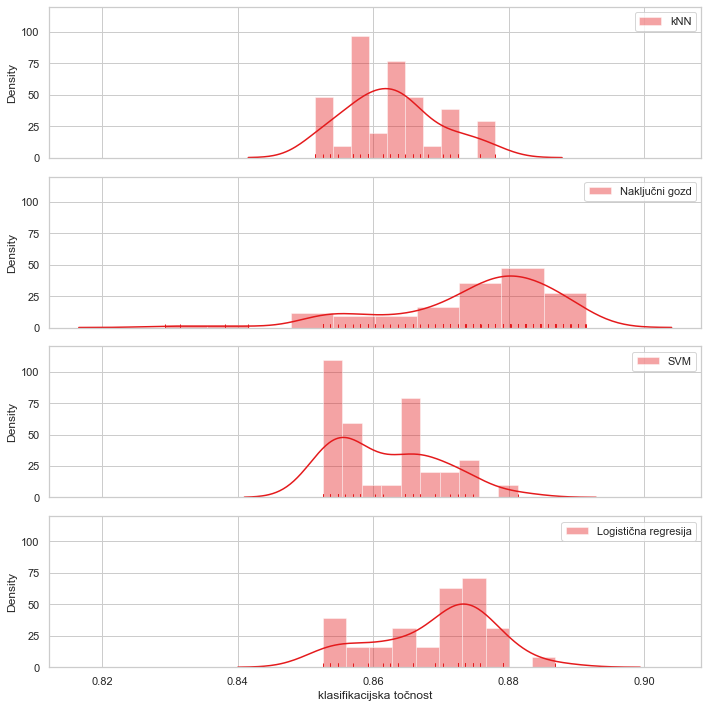

In [15]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10,10), sharex=True, sharey=True)

# plt.xlim([0.8, 0.9])
sns.distplot(x_knn2, label="kNN", rug=True, bins=10, ax=axes[0])
axes[0].legend()
sns.distplot(x_gozd2, label="Naključni gozd", rug=True, bins=10, ax=axes[1])
axes[1].legend()
sns.distplot(x_svm2, label="SVM", rug=True, bins=10, ax=axes[2])
axes[2].legend()
sns.distplot(x_logreg2, label="Logistična regresija", rug=True, bins=10, ax=axes[3])
axes[3].legend()
plt.tight_layout()

plt.show()

## 2.1 Vrečenje dreves

Poglejmo si še  vrečenje dreves, tokrat na 1000 ponovitvah, da bomo rezultat primerjali z najboljšim algoritmom iz naše množice algoritmov.

In [16]:
prostor_vrecenje = {
    'n_estimators': hp.choice('n_estimators', range(1, 51)),
    'max_samples': hp.choice('max_samples', range(1, 51)),
    'max_features': hp.choice('max_features', range(1, 31)),
}

def kriterijska_funkcija_vrecenje(parametri):
    n_estimators = parametri["n_estimators"]
    max_samples = parametri["max_samples"]
    max_features = parametri["max_features"]
    model = BaggingClassifier(n_estimators=n_estimators, max_samples=max_samples, max_features=max_features)
    return 1-cross_val_score(model, x_train, y_train).mean() 

def poisci_najboljse_parametre(prostor, kriterijska_fun, n_izracunov):
    trials = Trials()
    best = fmin(fn=kriterijska_fun,
                space=prostor,
                algo=tpe.suggest,
                max_evals=n_izracunov,
                trials=trials)
    best = space_eval(prostor, best)
    best_value = kriterijska_fun(best)
    # vse vrednosti paramtrov in kriterijske funkcije, ki smo jih preizkusili
    xs = [trial["misc"]["vals"] for trial in trials.trials]
    ys = [1-trial["result"]["loss"] for trial in trials.trials]

    print(best, 1-best_value)
    return best, xs, ys

In [17]:
best_vrecenje, xs_vrecenje, ys_vrecenje = poisci_najboljse_parametre(prostor_vrecenje, kriterijska_funkcija_vrecenje, 300)

100%|██████████| 300/300 [01:07<00:00,  4.43trial/s, best loss: 0.1197114794352363] 
{'max_features': 24, 'max_samples': 49, 'n_estimators': 29} 0.8702823818293431


In [18]:
model_vrecenje = BaggingClassifier(
                n_estimators = best_vrecenje["n_estimators"],
                max_samples = best_vrecenje["max_samples"],
                max_features = best_vrecenje["max_features"])

# zgradimo in naučimo model
model_vrecenje.fit(x_train, y_train)
y_predict_vrecenje = model_vrecenje.predict(x_test)

In [19]:
# model evalviramo na testni množici
acc_vrecenje = accuracy_score(y_test, y_predict_vrecenje)
print('Klasifikacijska točnost najboljšega vrečenja je:', acc_vrecenje)

Klasifikacijska točnost najboljšega vrečenja je: 0.8837209302325582


Končno izrišemo primerjavo med njaboljšim algoritmom in vrečenjem.

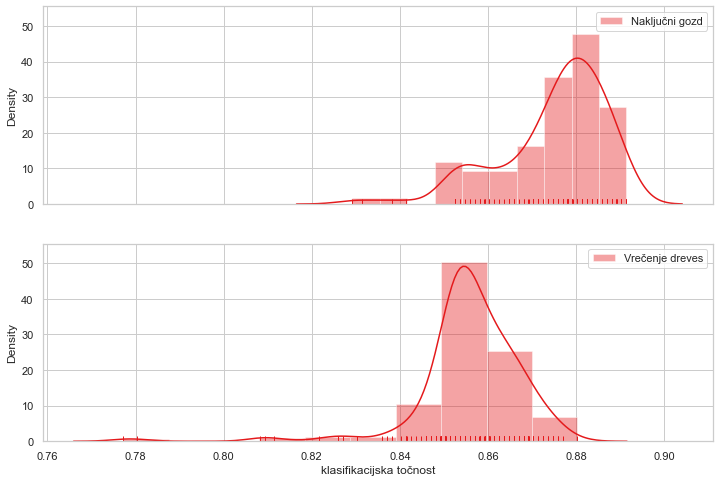

In [20]:
x_vrecenje = pd.Series(ys_vrecenje, name="klasifikacijska točnost")

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,8), sharex=True, sharey=True)

sns.distplot(x_gozd2, label="Naključni gozd", rug=True, bins=10, ax=axes[0])
axes[0].legend()
sns.distplot(x_vrecenje, label="Vrečenje dreves", rug=True, bins=10, ax=axes[1])
axes[1].legend()

plt.show()

# 3. ZAKLJUČEK

Ugotovili smo, da je med našimi algoritmi najboljši Naključni gozd, ki "zmaga" tudi proti Vrečenju dreves. Ima pa naključni gozd nekoliko bolj razpotegnjeno porazdelitev točnosti, zato bi bilo zanimivo primerjati tudi, ali je naključni gozd v povprečju najboljši?

In [21]:
from statistics import mean

knn_avg, gozd_avg, svm_avg, logreg_avg, vrecenje_avg = mean(x_knn2), mean(x_gozd2), mean(x_svm2), mean(x_logreg2), mean(x_vrecenje)
knn_top, gozd_top, svm_top, logreg_top, vrecenje_top = max(x_knn2), max(x_gozd2), max(x_svm2), max(x_logreg2), max(x_vrecenje)

In [22]:
print('Najboljši kNN:', knn_top, '|  Povprečen kNN:', knn_avg)
print('Najboljši RF: ', gozd_top, '|  Povprečen RF: ', gozd_avg)
print('Najboljši SVC:', svm_top, '|  Povprečen SVC:', svm_avg)
print('Najboljša LR: ', logreg_top, '|  Povprečna LR: ', logreg_avg)
print('-'*80)
print('Najboljše vrečenje:', vrecenje_top, '|  Povprečno vrečenje:', vrecenje_avg)

Najboljši kNN: 0.8780417434008594 |  Povprečen kNN: 0.8627142654766965
Najboljši RF:  0.8913812154696131 |  Povprečen RF:  0.8749969955924529
Najboljši SVC: 0.8813627992633517 |  Povprečen SVC: 0.8619819345786196
Najboljša LR:  0.8869122160834868 |  Povprečna LR:  0.869145222570637
--------------------------------------------------------------------------------
Najboljše vrečenje: 0.8802885205647637 |  Povprečno vrečenje: 0.8560555964804584


Opazimo, da je naključni gozd najboljši algoritem na naših podatkih (tako v povprečju, kot tudi v najboljšem primeru).

Dodatna razlaga, komentarji grafov in ideje za izboljšave so zapisane v priloženem poročilu.